In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.28
#EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
file_dir = '/content/drive/MyDrive/데이콘/도배 하자 유형 분류'

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정


In [ ]:
all_img_list = glob.glob(file_dir + '/train/*/*')

In [ ]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[-2]).astype(str)

In [ ]:
count_lb = df['label'].value_counts().to_frame().reset_index()
count_lb.columns = ['label','count']
count_lb

,label,count
0,훼손,1405
1,오염,595
2,걸레받이수정,307
3,꼬임,210
4,터짐,162
5,곰팡이,145
6,오타공,142
7,몰딩수정,130
8,면불량,99
9,석고수정,57


In [ ]:
from sklearn.preprocessing import LabelEncoder
df['label'] = [str(i) for i in df['label']]
le = LabelEncoder()

df['label_num'] = le.fit_transform(df['label'])
labels = df[['label_num','label']].drop_duplicates().reset_index(drop = True)
labels = pd.merge(labels, count_lb, on = 'label', how ='inner' )

In [ ]:
def label_decoder(pred):
	if pred==0:
		return '가구수정'
	if pred==1:
		return '걸레받이수정'
	if pred==2:	
		return '곰팡이' 
	if pred==3:	
		return '꼬임'   
	if pred==4:	
		return '녹오염' 
	if pred==5:	
		return '들뜸' 
	if pred==6:	
		return '면불량' 
	if pred==7:	
		return '몰딩수정'
	if pred==8:	
		return '반점' 
	if pred==9:	
		return '석고수정'
	if pred==10:	
		return '오염' 
	if pred==11:	
		return '오타공' 
	if pred==12:	
		return '울음' 
	if pred==13:	
		return '이음부불량' 
	if pred==14:	
		return '창틀,문틀수정' 
	if pred==15:	
		return '터짐' 
	if pred==16:	
		return '틈새과다'
	if pred==17:	
		return '피스' 
	if pred==18:	
		return '훼손' 
	else:
		return 'NaN' 
     

In [ ]:
df['re_label'] = [label_decoder(i) for i in df.label_num]

In [ ]:
labels['re_label'] = [label_decoder(i) for i in labels.label_num]

In [ ]:
labels = labels.sort_values(by = 'count', ascending = False)

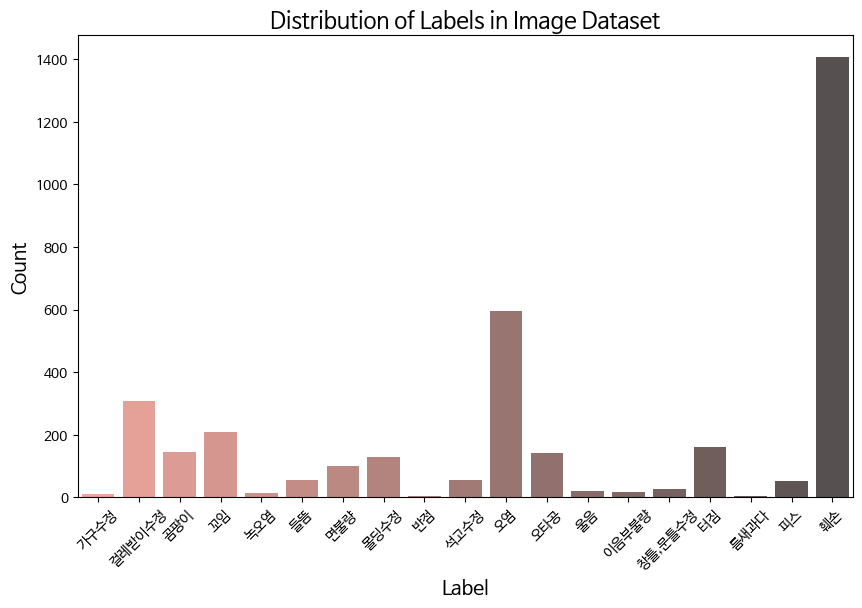

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns


#한글 display 안됨. 수정 필요
matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

x = labels['label_num']
y = labels['count']

plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(labels['label_num'], labels['re_label'])
plt.xticks(rotation=45)
plt.show()


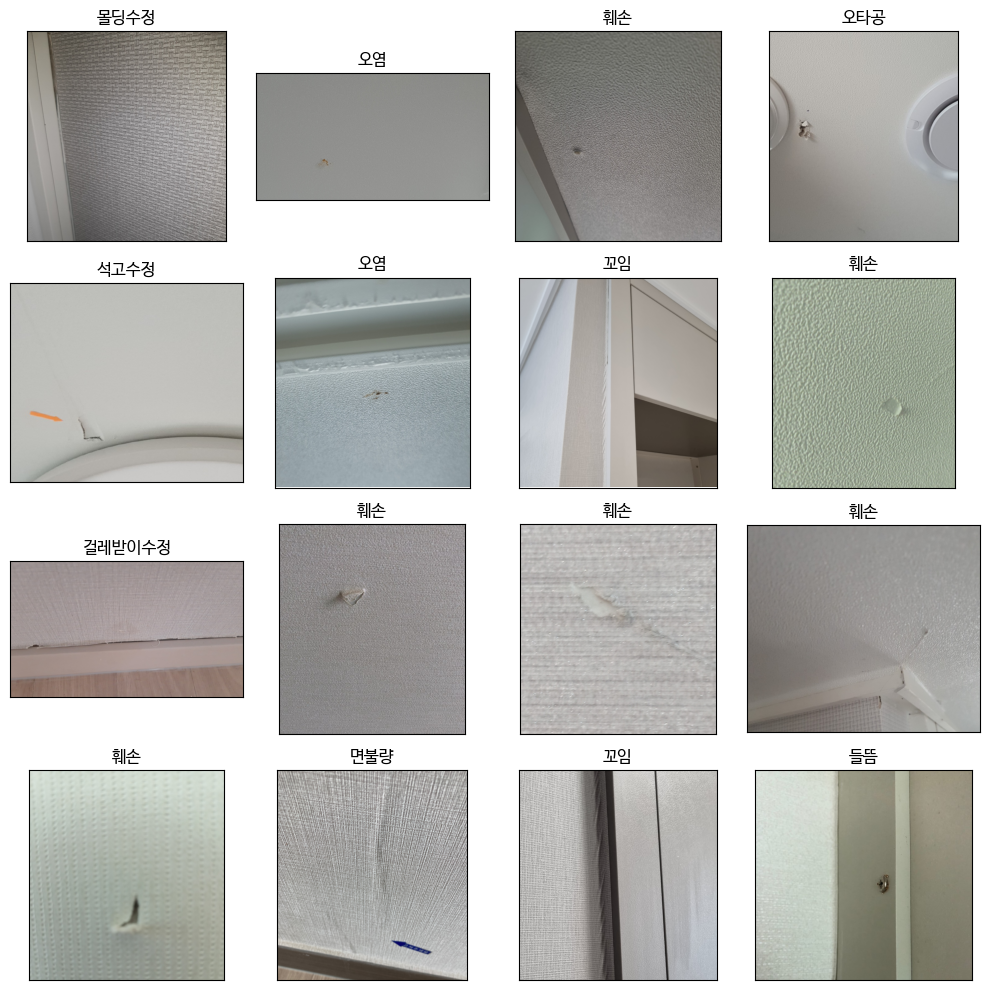

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.img_path[random_index[i]]))
    ax.set_title(df.re_label[random_index[i]])
plt.tight_layout()
plt.show()


In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from pathlib import Path

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()


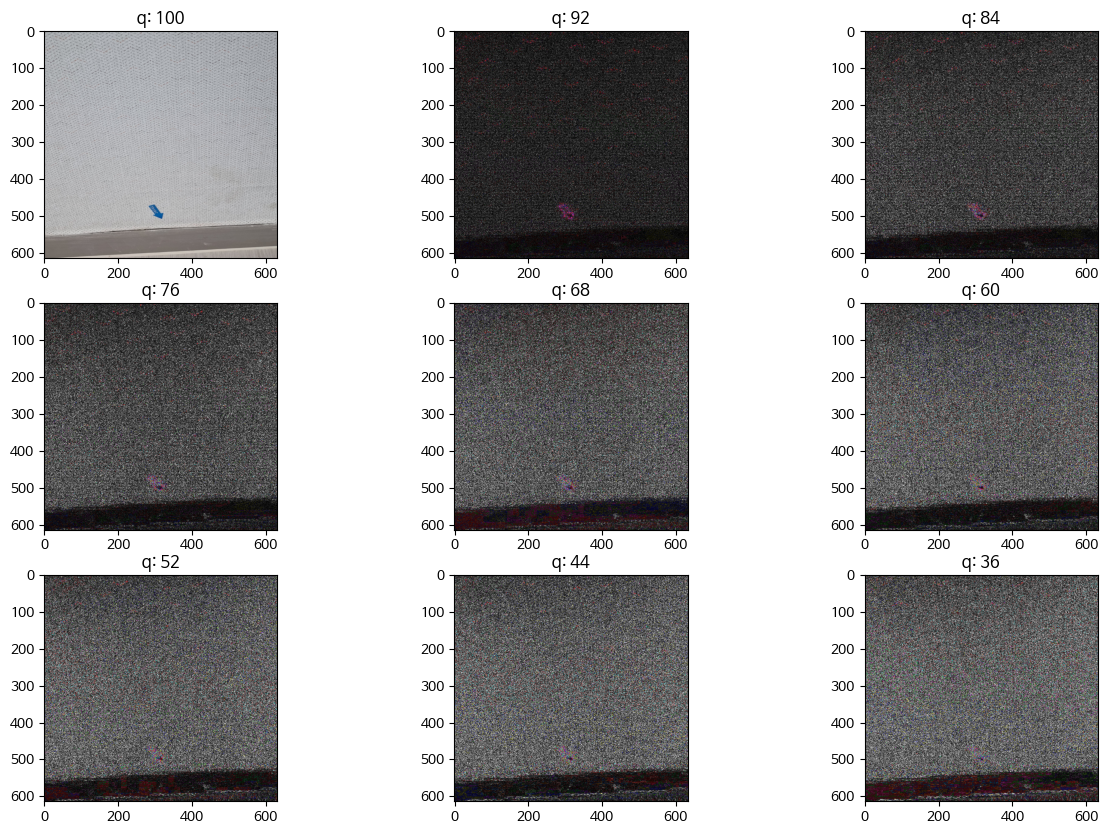

In [ ]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/데이콘/도배 하자 유형 분류/train/걸레받이수정')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()
